# NPL Research

We are looking at two types of text analysis: Text Classification and sentiment analysis.

Goal for text classification is to group the mined data into
- Industry - we might only look at 1 industry

- Publication region - we need to convert .txt or HTML to into table format for this information

- Abstract summarization 
-- summaries each abstract within a few words by remove stop words, group similar words.
-- Use Deep learning models, such as FastText or Word2Vec
-- Use Recurrent Neural Networks and Natural (RNN)



Goal for text sentimental analysis is not clear yet
- Describe if the piece is on problem statement or solution design
-- Not sure how can this be link back to the sentimental score
-- Require paid APIs, not sure how to do it without

- Describe if the piece is fiction or not
-- Model: Fictormeter
-- We might not need this as we are scraping from academic sources?

Below steps are tested on the sample PubMed text (abstract-Home care service.txt).  

# Pre-Process raw text

This created from colab with the text file stored in gdrive/MyDrive/Colab Notebooks/Ilab2/RAW/PubMed/.

The usual steps are 
- puncturation removal
- stopwords removal
- stemming & lemmatization
- vectorizer (tf-idf)
- POS tagging

# Set up env

In [ ]:
# Import library
import numpy as np
import os # use ls comment
import string
import pathlib # set working path to a variable

In [ ]:
# Set up master working folder
dir = pathlib.Path('/content/gdrive/MyDrive/Colab Notebooks/Ilab2')
text_dir = dir / 'RAW/PubMed'

In [ ]:
# Mount G drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Read in file
import pandas as pd
df = pd.read_fwf(text_dir/'abstract-Home care service.txt', header=None, names = ['Content'])

# Pre-process words - Exploration

##  Remove stopwords

In [ ]:
# create word cloud on content
## https://colab.research.google.com/github/gal-a/blog/blob/master/docs/notebooks/nlp/nltk_preprocess.ipynb#scrollTo=AdFlT_KXebxs
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger') 
nltk.download('omw-1.4') # use in stemming

from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
# 1) Create stopword list:
stops = set(stopwords.words('english'))
stops.update(["br", "href"])
print(f'There are {len(stops)} words in the default stop words list.')
print(stops)

There are 181 words in the default stop words list.
{'ours', 'more', 'myself', 'd', 'we', 're', 'if', 'mustn', 'itself', 'while', "didn't", 's', "haven't", 'some', 'which', 'all', 'at', 'themselves', 'now', 'where', 'yourself', 'yours', 'our', 've', 'am', 'won', 'for', 'be', 'during', 'under', 'before', 'should', 'have', 'hers', 'yourselves', 'after', 'own', 'down', 'has', 'as', "it's", 'o', 'other', 'wasn', 'any', 'those', 'himself', 'no', 'having', 'her', 'very', 'are', 'so', 'against', 'him', "isn't", 'again', 'same', "wasn't", 'a', 'doing', 'weren', 'out', 'but', 'mightn', 'br', 'had', 'into', 'such', 'nor', 'was', 'through', 'ourselves', 'few', 'their', 'can', 'hasn', 'ma', "that'll", 'here', 'me', "wouldn't", 'm', 'he', 'from', 'herself', 'once', 'each', 'most', "doesn't", 'further', "don't", 'them', 'than', "aren't", "you've", 'does', "shouldn't", "hasn't", 'over', 'how', 'his', 'too', 'or', 't', 'doesn', 'did', 'not', "mustn't", 'an', 'hadn', "you'll", 'then', 'they', "should'v

In [ ]:
# 2) Create a custom stopword list from word account
## https://medium.com/analytics-vidhya/build-a-customized-stopwords-list-using-python-nlp-6fc78d4eae3c

## sklearn library - CountVectorizer to find term frequency (tf), TfidfTransformer (tf-idf) to find term-frequency times inverse document-frequency (idf) which is good for text summarisation
## Tf means term-frequency 
## tf-idf means term-frequency times inverse document-frequency
## words with low tf-idf are candidate of stopwords

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer


#using the count vectorizer
count = CountVectorizer()
word_count=count.fit_transform(df['Content'])

tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(word_count)
df_idf = pd.DataFrame(tfidf_transformer.idf_, index=count.get_feature_names(),columns=["idf_weights"])


#inverse document frequency
df_idf.sort_values(by=['idf_weights'])

#tfidf
tf_idf_vector=tfidf_transformer.transform(word_count)
feature_names = count.get_feature_names()

first_document_vector=tf_idf_vector[1]
df_tfifd= pd.DataFrame(first_document_vector.T.todense(), index=feature_names, columns=["tfidf"])

df_tfifd.sort_values(by=["tfidf"],ascending=True)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,tfidf
00,0.000000
open,0.000000
operations,0.000000
opinions,0.000000
opn,0.000000
...,...
dimonte,0.000000
øst,0.000000
of,0.201662
print,0.692579


In [ ]:
## require manual judgement to which words from df_tfifd are to be in the customstop word list
stop_len = int(len(df_tfifd)*0.10) # 1378 out of 3447, 0.1 is the number we chose = we will remove 10% of all the unique words in the .txt
custom_stopwords = df_tfifd[:stop_len]

print(f'Use {stop_len} words from tfifd as custom stopword list.')
print(custom_stopwords)

Use 344 words from tfifd as custom stopword list.
                  tfidf
00                  0.0
000                 0.0
0000                0.0
0000000000000       0.0
0000000000000814    0.0
...                 ...
394                 0.0
40                  0.0
4000                0.0
403                 0.0
4040                0.0

[344 rows x 1 columns]


In [ ]:
## convert the custom_stopwords to list
custom_stopwords = pd.DataFrame(df_tfifd[:stop_len])
_index = custom_stopwords.index
custom_stopwords = list(_index)
_addition_stopwords = ["br", "href","indexed", "of","for","to","the","were","a","with","and","author","on","at","in","are","as","or","that","was"]
custom_stopwords = custom_stopwords + _addition_stopwords
print(f'There are {len(custom_stopwords)} words in the custom stop words list.')
print(custom_stopwords)

There are 364 words in the custom stop words list.
['00', '000', '0000', '0000000000000', '0000000000000814', '0000000000000869', '0000000000000880', '0000000000000904', '00001786', '0000338512', '0000356828', '00004045', '00005110', '00007', '00008', '00009', '00010', '00011', '00012', '00014', '00015555', '0002', '00021', '001', '005', '00571', '008', '009', '01', '011', '012', '013', '014', '017', '018', '01803', '02', '021', '02125', '027', '03', '031226', '04', '044', '04747', '05', '06', '062', '06941', '07', '0789', '08', '0808', '0886', '09540121', '0969733003ne608oa', '0b013e3181dbc07b', '0b013e318291ee9c', '10', '100', '10001', '1002', '1007', '10126', '10133867', '1016', '1017', '103', '103031', '1048291117739418', '105', '105925', '106', '1061', '107', '1071', '1080', '1089', '1093', '1097', '11', '1111', '11141615', '11183463', '1130', '1135', '1136', '11482636', '115', '1155', '116', '1177', '11771472', '11839975', '1186', '1191', '11951746', '12', '120', '1207', '12084',

In [ ]:
## combined the custom_stopwords with the default stopword list
final_stopwords = list(stops) + custom_stopwords

print(f'There are {len(final_stopwords)} final stop words.')
print(final_stopwords)

There are 545 final stop words.
['ours', 'more', 'myself', 'd', 'we', 're', 'if', 'mustn', 'itself', 'while', "didn't", 's', "haven't", 'some', 'which', 'all', 'at', 'themselves', 'now', 'where', 'yourself', 'yours', 'our', 've', 'am', 'won', 'for', 'be', 'during', 'under', 'before', 'should', 'have', 'hers', 'yourselves', 'after', 'own', 'down', 'has', 'as', "it's", 'o', 'other', 'wasn', 'any', 'those', 'himself', 'no', 'having', 'her', 'very', 'are', 'so', 'against', 'him', "isn't", 'again', 'same', "wasn't", 'a', 'doing', 'weren', 'out', 'but', 'mightn', 'br', 'had', 'into', 'such', 'nor', 'was', 'through', 'ourselves', 'few', 'their', 'can', 'hasn', 'ma', "that'll", 'here', 'me', "wouldn't", 'm', 'he', 'from', 'herself', 'once', 'each', 'most', "doesn't", 'further', "don't", 'them', 'than', "aren't", "you've", 'does', "shouldn't", "hasn't", 'over', 'how', 'his', 'too', 'or', 't', 'doesn', 'did', 'not', "mustn't", 'an', 'hadn', "you'll", 'then', 'they', "should've", 'these', 'your',

In [ ]:
## write the stopwords into a .csv
import csv # Import the csv module to work with csv files
with open('final_stop_words.csv', 'w', newline='') as f:
     writer = csv.writer(f)
     writer.writerow(final_stopwords)

### Word cloud on current documents (after stowords)

In [ ]:
from wordcloud import WordCloud 
import matplotlib.pyplot as plt

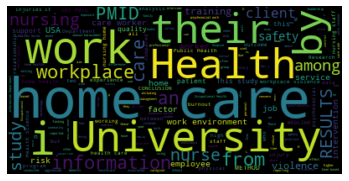

In [ ]:
textt = " ".join(review for review in df.Content)
wordcloud = WordCloud(stopwords=custom_stopwords).generate(textt)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('wordcloud11.png')
plt.show()

This .txt is about home care, workplace Health

##  Stemming & Lemmatization & UPOS tags

Majoirty of the processing codes are from https://colab.research.google.com/github/gal-a/blog/blob/master/docs/notebooks/nlp/nltk_preprocess.ipynb#scrollTo=-44aMwUcQZxm

UPOS = universal Parts of Speech tagging = noun, adjective, adverb, pronoun

In [ ]:
# defines character properties for all Unicode characters
import unicodedata 

# check if a particular string matches a given regular expression (or if a given regular expression matches a particular string, which comes down to the same thing).
import re 

In [ ]:
# Basic info on the orginal text
print("text contents:")
print(df.head().to_string())
print(df.describe())


# Convert text data to list 
li_quotes = df['Content'].tolist()
print()
print("len(li_quotes):", len(li_quotes))

text contents:
                                                                            Content
0  1. Palliat Support Care. 2022 Jan 26:1-8. doi: 10.1017/S1478951521001887. Online
1                                                                   ahead of print.
2  The burden in palliative care assistance: A comparison of psychosocial risks and
3                 burnout between inpatient hospice and home care services workers.
4                    Fattori A(1), Pedruzzi M(2), Cantarella C(2), Bonzini M(1)(2).
                    Content
count                  2058
unique                 1971
top     Author information:
freq                     73

len(li_quotes): 2058


In [ ]:
# Get stemmer and lemmatizer
stopwords = final_stopwords # stopwords = nltk.corpus.stopwords.words('english')
stemmer = nltk.stem.PorterStemmer()
lemmatizer = nltk.stem.WordNetLemmatizer()

In [ ]:
# Constants
# POS (Parts Of Speech) for: nouns, adjectives, verbs and adverbs
DI_POS_TYPES = {'NN':'n', 'JJ':'a', 'VB':'v', 'RB':'r'} 
POS_TYPES = list(DI_POS_TYPES.keys())

# Constraints on tokens
MIN_STR_LEN = 3
RE_VALID = '[a-zA-Z]'

### Apply stemmer & lemmatizer & POS tags

In [ ]:
# Remove accents function
def remove_accents(data):
    return ''.join(x for x in unicodedata.normalize('NFKD', data) if x in string.ascii_letters or x == " ")

# Process all quotes
li_tokens = []
li_token_lists = []
li_lem_strings = []

for i,text in enumerate(li_quotes):
    # Tokenize by sentence, then by lowercase word
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]

    # Process all tokens per quote
    li_tokens_quote = []
    li_tokens_quote_lem = []
    for token in tokens:
        # Remove accents
        t = remove_accents(token)

        # Remove punctuation
        t = str(t).translate(string.punctuation)
        li_tokens_quote.append(t)
        
        # Add token that represents "no lemmatization match"
        li_tokens_quote_lem.append("-") # this token will be removed if a lemmatization match is found below

        # Process each token
        if t not in stopwords:
            if re.search(RE_VALID, t):
                if len(t) >= MIN_STR_LEN:
                    # Note that the POS (Part Of Speech) is necessary as input to the lemmatizer 
                    # (otherwise it assumes the word is a noun)
                    pos = nltk.pos_tag([t])[0][1][:2]
                    pos2 = 'n'  # set default to noun
                    if pos in DI_POS_TYPES:
                      pos2 = DI_POS_TYPES[pos]
                    
                    stem = stemmer.stem(t)
                    lem = lemmatizer.lemmatize(t, pos=pos2)  # lemmatize with the correct POS
                    
                    if pos in POS_TYPES:
                        li_tokens.append((t, stem, lem, pos))

                        # Remove the "-" token and append the lemmatization match
                        li_tokens_quote_lem = li_tokens_quote_lem[:-1] 
                        li_tokens_quote_lem.append(lem)

    # Build list of token lists from lemmatized tokens
    li_token_lists.append(li_tokens_quote)
    
    # Build list of strings from lemmatized tokens
    str_li_tokens_quote_lem = ' '.join(li_tokens_quote_lem)
    li_lem_strings.append(str_li_tokens_quote_lem)
    
# Build resulting dataframes from lists
df_token_lists = pd.DataFrame(li_token_lists)

print("df_token_lists.head(5):")
print(df_token_lists.head(5).to_string())


df_token_lists.head(5):
        0        1          2           3     4           5         6         7           8     9             10     11          12      13    14    15    16    17       18    19    20    21    22    23    24    25    26    27    28    29    30    31    32    33    34    35    36    37    38
0                      palliat     support  care                             jan               doi                    s              online  None  None  None  None     None  None  None  None  None  None  None  None  None  None  None  None  None  None  None  None  None  None  None  None  None
1    ahead       of      print              None        None      None      None        None  None          None   None        None    None  None  None  None  None     None  None  None  None  None  None  None  None  None  None  None  None  None  None  None  None  None  None  None  None  None
2      the   burden         in  palliative  care  assistance                   a  comparison    o

In [ ]:
# Replace None with empty string
for c in df_token_lists:
    if str(df_token_lists[c].dtype) in ('object', 'string_', 'unicode_'):
        df_token_lists[c].fillna(value='', inplace=True)

df_lem_strings = pd.DataFrame(li_lem_strings, columns=['lem quote'])

print()
print("")
print("df_lem_strings.head():")
print(df_lem_strings.head().to_string())



df_lem_strings.head():
                                                                           lem quote
0                                - - palliat support care - - jan - doi - - - online
1                                                                    ahead - print -
2         - burden - palliative care assistance - - comparison - psychosocial risk -
3                           burnout - inpatient hospice - home care service worker -
4  fattori - - - - - pedruzzi - - - - - cantarella - - - - - bonzini - - - - - - - -


### Find the most popular lemmatized words and group results by Part of Speech (POS)

In [ ]:
# Add counts
print("Group by lemmatized words, add count and sort:")
df_all_words = pd.DataFrame(li_tokens, columns=['token', 'stem', 'lem', 'pos'])
df_all_words['counts'] = df_all_words.groupby(['lem'])['lem'].transform('count')
df_all_words = df_all_words.sort_values(by=['counts', 'lem'], ascending=[False, True]).reset_index()

print("Get just the first row in each lemmatized group")
df_words = df_all_words.groupby('lem').first().sort_values(by='counts', ascending=False).reset_index()
print("df_words.head(20):")
print(df_words.head(20))

Group by lemmatized words, add count and sort:
Get just the first row in each lemmatized group
df_words.head(20):
            lem  index        token      stem pos  counts
0          care      2         care      care  NN     277
1          home     18         home      home  NN     263
2        health     28       health    health  NN     212
3          work    119         work      work  NN     190
4           doi      4          doi       doi  NN     146
5        worker     21      workers    worker  NN     112
6         study     64        study     studi  NN      99
7       nursing    291      nursing      nurs  NN      97
8      violence    620     violence   violenc  NN      96
9    university     43   university   univers  NN      92
10    workplace    725    workplace  workplac  NN      90
11         pmid    257         pmid      pmid  NN      80
12  information     26  information    inform  NN      79
13      medline    468      medline    medlin  NN      79
14        nurse 

In [ ]:
## Top 10 words per Part Of Speech (POS)
df_words = df_words[['lem', 'pos', 'counts']].head(200)
for v in POS_TYPES:
    df_pos = df_words[df_words['pos'] == v]
    print()
    print("POS_TYPE:", v)
    print(df_pos.head(10).to_string())

    ## pos: NN = nouns, JJ = adjectives, VB = verbs and RB = adverbs


POS_TYPE: NN
          lem pos  counts
0        care  NN     277
1        home  NN     263
2      health  NN     212
3        work  NN     190
4         doi  NN     146
5      worker  NN     112
6       study  NN      99
7     nursing  NN      97
8    violence  NN      96
9  university  NN      92

POS_TYPE: JJ
              lem pos  counts
22   occupational  JJ      49
26           high  JJ      46
36       physical  JJ      42
64         social  JJ      25
67         sexual  JJ      24
84       clinical  JJ      20
95            old  JJ      19
113       related  JJ      17
118      personal  JJ      16
120      national  JJ      16

POS_TYPE: VB
        lem pos  counts
21      use  VB      49
43  control  VB      36
45  include  VB      36
47   demand  VB      33
48  compare  VB      32
53   report  VB      29
57  improve  VB      27
60   survey  VB      26
61  provide  VB      26
65     need  VB      25

POS_TYPE: RB
               lem pos  counts
80            well  RB      21
17

### Word frequency before and after stopwords

#### Before

li_token_lists_flat[:10]: ['', '', 'palliat', 'support', 'care', '', '', 'jan', '', 'doi']
[('and', 691), ('of', 660), ('the', 639), ('to', 345), ('in', 334), ('care', 268), ('for', 250), ('a', 240), ('home', 234), ('health', 212), ('with', 150), ('work', 148), ('doi', 146), ('was', 110), ('were', 108), ('workers', 103), ('nursing', 97), ('violence', 96), ('university', 92), ('is', 90), ('workplace', 86), ('that', 83), ('study', 82), ('as', 82), ('pmid', 80), ('information', 79), ('indexed', 79), ('medline', 79), ('author', 77), ('on', 75), ('this', 74), ('their', 73), ('from', 64), ('by', 62), ('job', 62), ('environment', 61), ('safety', 60), ('or', 60), ('at', 55), ('are', 55), ('among', 53), ('staff', 53), ('an', 52), ('s', 49), ('occupational', 49), ('usa', 47), ('research', 45), ('nurses', 45), ('results', 44), ('training', 44), ('support', 43), ('j', 43), ('psychosocial', 42), ('physical', 42), ('aides', 41), ('working', 40), ('department', 39), ('be', 39), ('risk', 37), ('data',

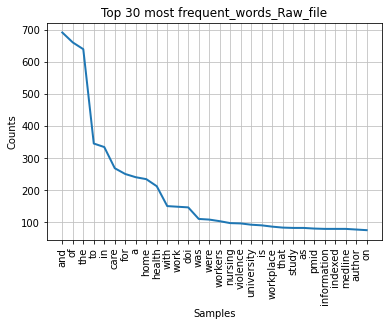

In [ ]:
li_token_lists_flat = [y for x in li_token_lists for y in x]  # flatten the list of token lists to a single list
print("li_token_lists_flat[:10]:", li_token_lists_flat[:10])

di_freq = nltk.FreqDist(li_token_lists_flat)
del di_freq['']
li_freq_sorted = sorted(di_freq.items(), key=lambda x: x[1], reverse=True)  # sorted list
print(li_freq_sorted)
    
di_freq.plot(30, title='Top 30 most frequent_words_Raw_file',cumulative=False)

#### After

[('care', 277), ('home', 263), ('health', 212), ('work', 190), ('doi', 146), ('worker', 112), ('study', 99), ('nursing', 97), ('violence', 96), ('university', 92), ('workplace', 90), ('pmid', 80), ('information', 79), ('medline', 79), ('nurse', 70), ('job', 67), ('environment', 61), ('safety', 60), ('staff', 56), ('injury', 53), ('aide', 49), ('occupational', 49), ('use', 49), ('support', 48), ('usa', 47), ('high', 46), ('service', 46), ('client', 45), ('research', 45), ('result', 45), ('science', 45), ('intervention', 44), ('training', 44), ('factor', 43), ('patient', 43), ('risk', 43), ('department', 42), ('physical', 42), ('psychosocial', 42), ('group', 39), ('data', 37), ('experience', 37), ('method', 37), ('control', 36), ('employee', 36), ('include', 36), ('quality', 35), ('demand', 33), ('compare', 32), ('oregon', 32), ('homecare', 31), ('satisfaction', 31), ('school', 31), ('report', 29), ('analysis', 28), ('healthcare', 28), ('public', 28), ('improve', 27), ('agency', 26), ('c

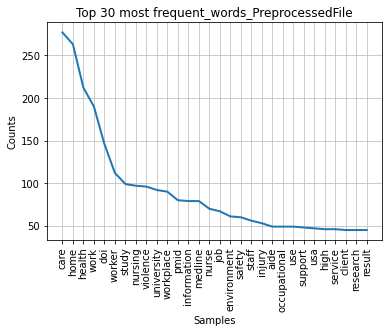

In [ ]:
li_lem_words = df_all_words['lem'].tolist()
di_freq2 = nltk.FreqDist(li_lem_words)
li_freq_sorted2 = sorted(di_freq2.items(), key=lambda x: x[1], reverse=True)  # sorted list
print(li_freq_sorted2)
    
di_freq2.plot(30, title='Top 30 most frequent_words_PreprocessedFile',cumulative=False)

# Conclusion

This text pre-process is an inital attempt on sample data, under the assmption of a strucutre dataframe, further refinement is required on the custom stoprwords list, introduce more POS. 

Most importantly, we need to create a process to convert the current text file to a dataframe format with each search result in a row, publication, datetime, author, title in different columns.

Once the dataframe and pre-process is ready, we can proceed to classified them within different modeling technique such as Word2Vec and FastText. 